In [79]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, LSTM, Bidirectional
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [80]:
data = pd.read_csv('data/processed/necklace_combined_old.csv')
data.head()

,label,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr
0,Falling,-1.517991,0.107120,0.817591,8.545183,-99.978637,-16.479995
1,Falling,-1.454817,0.098880,0.824000,6.958220,-98.879971,-15.625477
2,Falling,-1.392560,0.077822,0.815760,5.005036,-97.903378,-16.113773
3,Falling,-1.323893,0.077822,0.795618,0.000000,-108.767968,-16.479995
4,Falling,-1.239662,0.009156,0.807520,-14.282662,-124.881741,-14.770959


In [81]:
data.shape

(285516, 7)

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285516 entries, 0 to 285515
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   label   285516 non-null  object 
 1   x_acc   285516 non-null  float64
 2   y_acc   285516 non-null  float64
 3   z_acc   285516 non-null  float64
 4   x_gyr   285516 non-null  float64
 5   y_gyr   285516 non-null  float64
 6   z_gyr   285516 non-null  float64
dtypes: float64(6), object(1)
memory usage: 15.2+ MB


In [83]:
data.mean()

/tmp/ipykernel_19388/531903386.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.mean()


x_acc   -1.752597
y_acc   -0.134650
z_acc    0.564365
x_gyr   -5.453926
y_gyr   -0.867959
z_gyr    2.483676
dtype: float64

In [84]:
# check for null data
data.isnull().sum()

label    0
x_acc    0
y_acc    0
z_acc    0
x_gyr    0
y_gyr    0
z_gyr    0
dtype: int64

In [85]:
# count the datapoints of different activity
data['label'].value_counts()

Walking    98736
Running    98406
Stairs     61578
Sitting    14124
Falling    12672
Name: label, dtype: int64

### Balance this data 

In [86]:
# convert attributes to floats
data['x_acc'] = data['x_acc'].astype('float')
data['y_acc'] = data['y_acc'].astype('float')
data['z_acc'] = data['z_acc'].astype('float')
data['x_gyr'] = data['x_gyr'].astype('float')
data['y_gyr'] = data['y_gyr'].astype('float')
data['z_gyr'] = data['z_gyr'].astype('float')

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285516 entries, 0 to 285515
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   label   285516 non-null  object 
 1   x_acc   285516 non-null  float64
 2   y_acc   285516 non-null  float64
 3   z_acc   285516 non-null  float64
 4   x_gyr   285516 non-null  float64
 5   y_gyr   285516 non-null  float64
 6   z_gyr   285516 non-null  float64
dtypes: float64(6), object(1)
memory usage: 15.2+ MB


In [88]:
# frame size, Frames per second
Fs = 33

In [89]:
activities = data['label'].value_counts().index

In [90]:
activities

Index(['Walking', 'Running', 'Stairs', 'Sitting', 'Falling'], dtype='object')

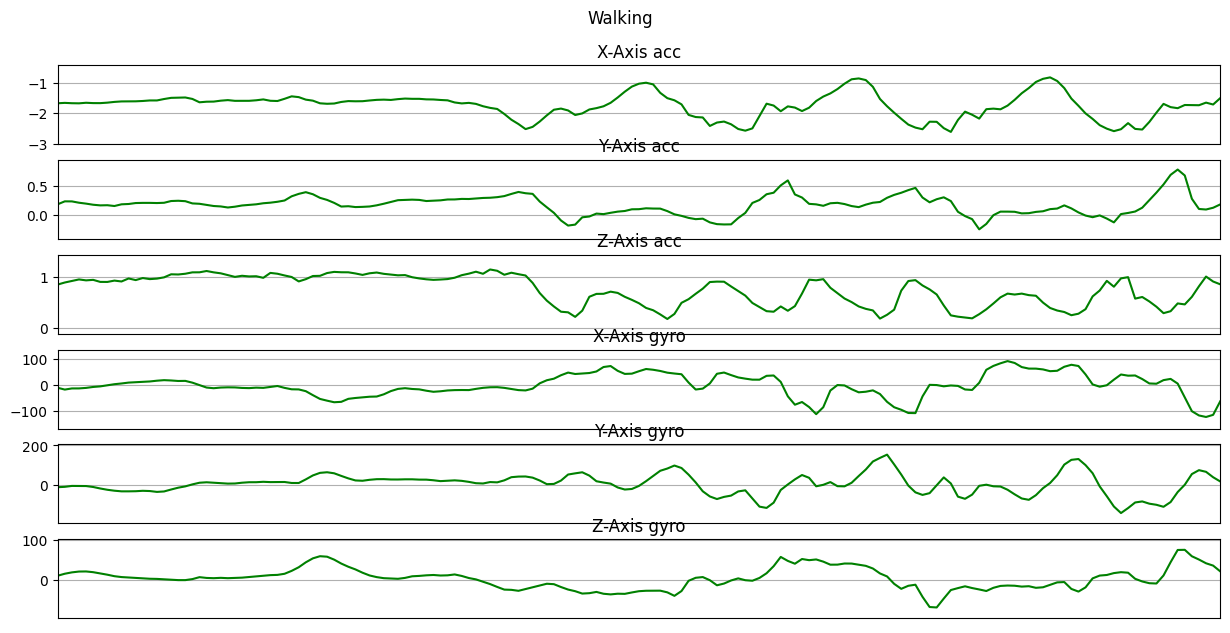

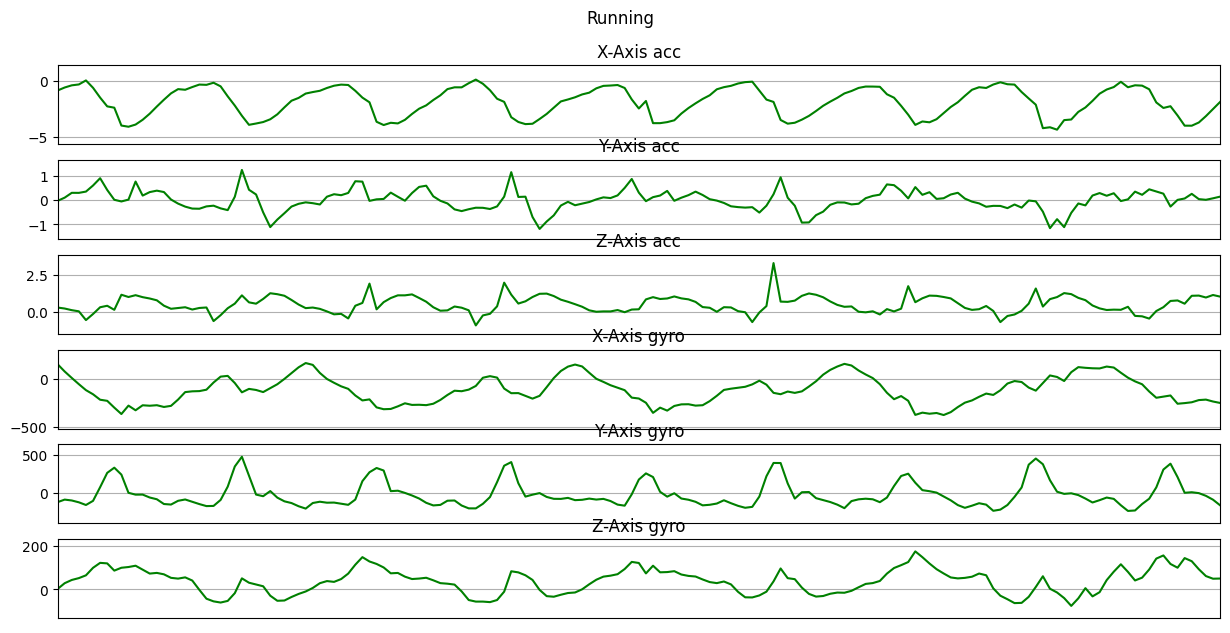

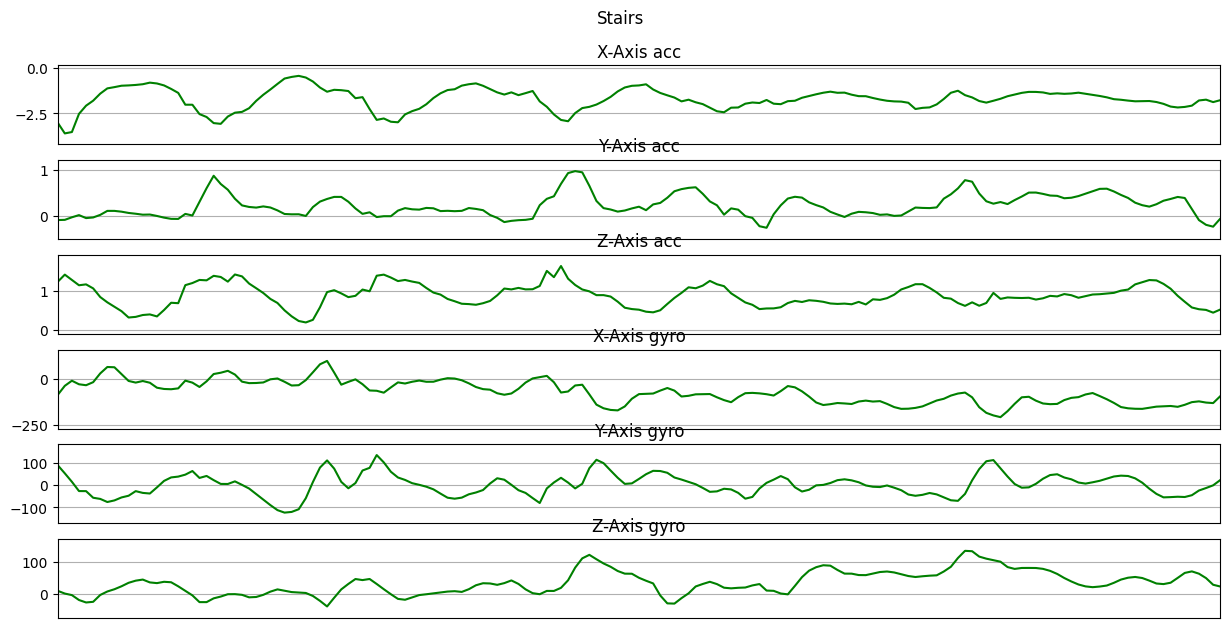

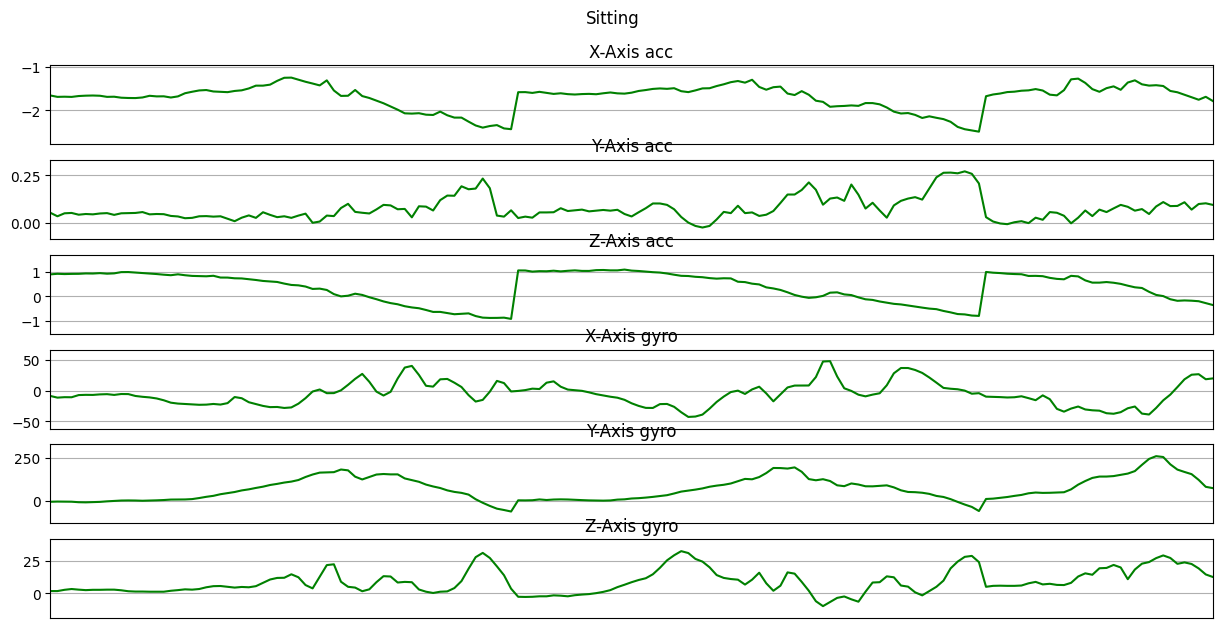

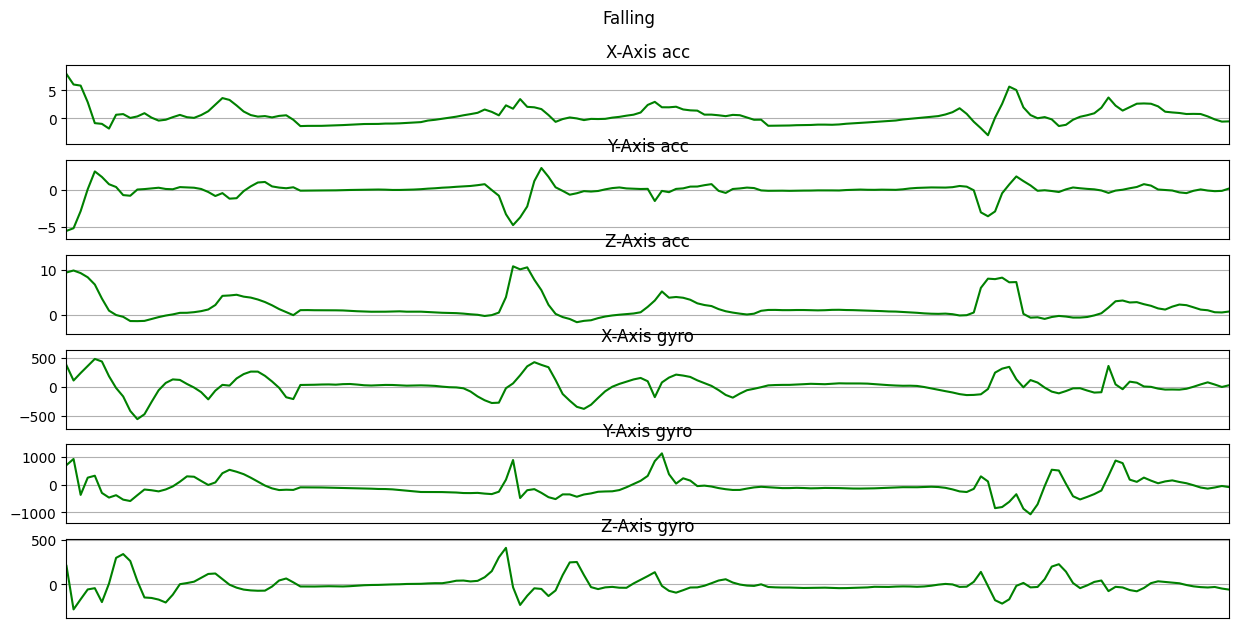

In [91]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=6, figsize=(15, 7), sharex=True)
    x_ticks = np.arange(len(data))
    plot_axis(ax0, x_ticks, data['x_acc'], 'X-Axis acc')
    plot_axis(ax1, x_ticks, data['y_acc'], 'Y-Axis acc')
    plot_axis(ax2, x_ticks, data['z_acc'], 'Z-Axis acc')
    plot_axis(ax3, x_ticks, data['x_gyr'], 'X-Axis gyro')
    plot_axis(ax4, x_ticks, data['y_gyr'], 'Y-Axis gyro')
    plot_axis(ax5, x_ticks, data['z_gyr'], 'Z-Axis gyro')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in activities:
    data_for_plot = data[(data['label'] == activity)][Fs*5:Fs*10]
    plot_activity(activity, data_for_plot)

In [92]:
counts = data['label'].value_counts()
counts

Walking    98736
Running    98406
Stairs     61578
Sitting    14124
Falling    12672
Name: label, dtype: int64

In [93]:
# calculate weights to balance weights on imbalance classes
# references: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
# references: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
n_classes = 5
n_total = data.shape[0]

weight_0 = n_total / (n_classes * counts[0]) # 
weight_1 = n_total / (n_classes * counts[1]) #
weight_2 = n_total / (n_classes * counts[2])
weight_3 = n_total / (n_classes * counts[3])
weight_4 = n_total / (n_classes * counts[4])
class_weight = {0: weight_0, 1: weight_1, 2:weight_2, 3: weight_3, 4: weight_4}

In [94]:
class_weight

{0: 0.5783422459893048,
 1: 0.5802816901408451,
 2: 0.9273311897106109,
 3: 4.0429906542056075,
 4: 4.50625}

In [95]:
data.shape

(285516, 7)

In [96]:
data['label'].value_counts()

Walking    98736
Running    98406
Stairs     61578
Sitting    14124
Falling    12672
Name: label, dtype: int64

In [97]:
data.head()

,label,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr
0,Falling,-1.517991,0.107120,0.817591,8.545183,-99.978637,-16.479995
1,Falling,-1.454817,0.098880,0.824000,6.958220,-98.879971,-15.625477
2,Falling,-1.392560,0.077822,0.815760,5.005036,-97.903378,-16.113773
3,Falling,-1.323893,0.077822,0.795618,0.000000,-108.767968,-16.479995
4,Falling,-1.239662,0.009156,0.807520,-14.282662,-124.881741,-14.770959


In [98]:
from sklearn.preprocessing import LabelEncoder

In [99]:
label = LabelEncoder()
data['label_id'] = label.fit_transform(data['label'])
data.tail()

,label,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr,label_id
285511,Walking,-1.337626,-0.301218,0.982391,0.244148,-46.510208,51.149022,4
285512,Walking,-1.334880,-0.326853,0.878933,12.939848,-31.250954,34.913175,4
285513,Walking,-1.387982,-0.292978,0.899075,9.521775,3.540147,13.916440,4
285514,Walking,-1.406293,-0.262764,0.964080,0.732444,37.842952,5.127110,4
285515,Walking,-1.647084,-0.297555,1.078524,6.469924,51.393170,19.775994,4


In [100]:
label.classes_

array(['Falling', 'Running', 'Sitting', 'Stairs', 'Walking'], dtype=object)

### Standardized data 

In [101]:
X = data[['x_acc', 'y_acc', 'z_acc', 'x_gyr', 'y_gyr', 'z_gyr']]
y = data['label_id']

In [102]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x_acc', 'y_acc', 'z_acc', 'x_gyr', 'y_gyr', 'z_gyr'])
scaled_X['label_id'] = y.values

scaled_X

,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr,label_id
0,0.208260,0.448161,0.304220,0.083190,-0.688908,-0.253846,0
1,0.264339,0.432887,0.311919,0.073759,-0.681271,-0.242408,0
2,0.319605,0.393853,0.302020,0.062153,-0.674483,-0.248944,0
3,0.380560,0.393853,0.277822,0.032410,-0.750002,-0.253846,0
4,0.455332,0.266568,0.292121,-0.052465,-0.862007,-0.230969,0
...,...,...,...,...,...,...,...
285511,0.368369,-0.308761,0.502207,0.033861,-0.317254,0.651431,4
285512,0.370807,-0.356281,0.377915,0.109305,-0.211189,0.434099,4
285513,0.323669,-0.293487,0.402113,0.088993,0.030640,0.153038,4
285514,0.307414,-0.237481,0.480208,0.036763,0.269075,0.035385,4


### Frame Preparation 

In [103]:
import scipy.stats as stats

In [119]:
Fs = 33
frame_size = Fs*2
hop_size = 66

In [120]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 6
    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x_acc = df['x_acc'].values[i: i + frame_size]
        y_acc = df['y_acc'].values[i: i + frame_size]
        z_acc = df['z_acc'].values[i: i + frame_size]
        x_gyr = df['x_gyr'].values[i: i + frame_size]
        y_gyr = df['y_gyr'].values[i: i + frame_size]
        z_gyr = df['z_gyr'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label_id'][i: i + frame_size])[0][0]
        frames.append([x_acc, y_acc, z_acc, x_gyr, y_gyr, z_gyr])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [130]:
X, y = get_frames(scaled_X, frame_size, hop_size)

/tmp/ipykernel_19388/3703171814.py:15: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['label_id'][i: i + frame_size])[0][0]


In [131]:
X.shape, y.shape

((4325, 66, 6), (4325,))

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7, stratify = y)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 7, stratify = y_train)

In [133]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3460, 66, 6)
(3460,)
(865, 66, 6)
(865,)


In [125]:
X_train.shape, X_test.shape

((2768, 66, 6), (865, 66, 6))

### LSTM

In [134]:
X_train = X_train.reshape(X_train.shape[0], 66, 6)
X_test = X_test.reshape(X_test.shape[0], 66, 6)

In [135]:
model = Sequential()
model.add(LSTM(units=256, input_shape= X_train[0].shape, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=256, input_shape= X_train[0].shape, return_sequences=True))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [136]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [137]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(X_train, y_train, epochs = 100, validation_split=0.1, verbose=1, callbacks = [es])

# count the number of epochs after early stopping
number_of_epochs = len(history.history['loss'])

Epoch 1/100
98/98 [==============================] - 27s 242ms/step - loss: 0.7411 - accuracy: 0.6901 - val_loss: 0.5733 - val_accuracy: 0.7919
Epoch 2/100
98/98 [==============================] - 23s 234ms/step - loss: 0.5355 - accuracy: 0.7832 - val_loss: 0.4768 - val_accuracy: 0.8150
Epoch 3/100
98/98 [==============================] - 23s 234ms/step - loss: 0.4446 - accuracy: 0.8288 - val_loss: 0.3851 - val_accuracy: 0.8584
Epoch 4/100
98/98 [==============================] - 23s 230ms/step - loss: 0.3650 - accuracy: 0.8600 - val_loss: 0.3192 - val_accuracy: 0.8873
Epoch 5/100
98/98 [==============================] - 23s 235ms/step - loss: 0.3455 - accuracy: 0.8661 - val_loss: 0.3261 - val_accuracy: 0.8757
Epoch 6/100
98/98 [==============================] - 23s 235ms/step - loss: 0.3137 - accuracy: 0.8831 - val_loss: 0.3012 - val_accuracy: 0.9075
Epoch 7/100
98/98 [==============================] - 23s 234ms/step - loss: 0.2820 - accuracy: 0.8892 - val_loss: 0.2717 - val_accuracy:

In [115]:
# convert the history.history dict to a pandas DataFrame:     
history_df = pd.DataFrame(history.history) 

# save history to csv: 
hist_csv_file = 'history/young_necklace_lstm.csv'
with open(hist_csv_file, mode='w') as f:
    history_df.to_csv(f)

    # count the number of epochs after early stopping
number_of_epochs = len(history.history['loss'])

In [ ]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

In [ ]:
plot_learningCurve(history, number_of_epochs)

### Confusion Matrix 

In [138]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score

In [139]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

28/28 [==============================] - 3s 91ms/step


0.922543352601156

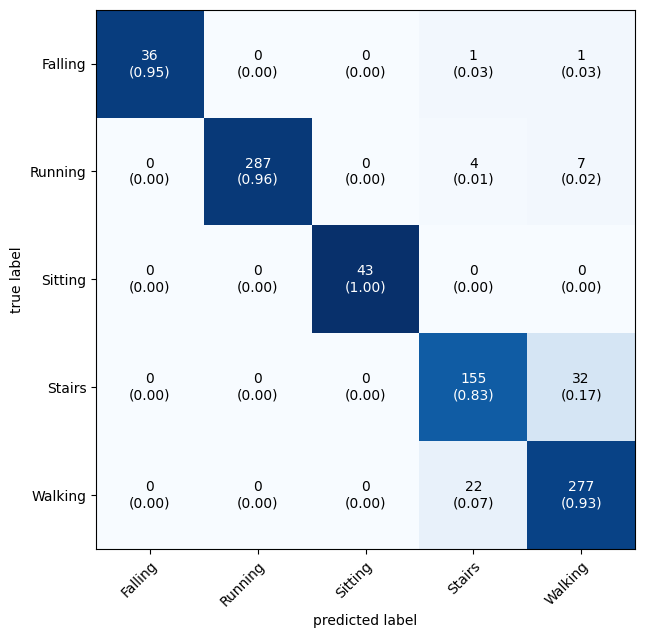

In [140]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

accuracy_score(y_test, y_pred)

In [143]:
model.save("models/new/lstm_6_young_necklace.h5")